In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, mean_absolute_error, accuracy_score, 
                             precision_score, recall_score, f1_score, confusion_matrix, 
                             classification_report)
import matplotlib.pyplot as plt
import seaborn as sns



In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE for binary classification probabilities"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.inf
    
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model_comprehensive(model, X_test, y_test, model_name="Model"):
    """
    Комплексная оценка модели с расчетом всех метрик
    """
    # Предсказания
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Расчет метрик
    metrics = {
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'MAE': mean_absolute_error(y_test, y_pred_proba),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0)
    }
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    # Детальный отчет
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return metrics, cm, report, y_pred_proba, y_pred

def plot_feature_importance(model, feature_names, top_n=15):
    """Визуализация важности признаков"""
    if hasattr(model, 'coef_'):
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': abs(model.coef_[0])
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance.head(top_n), y='feature', x='importance')
        plt.title(f'Top {top_n} Most Important Features (Logistic Regression)')
        plt.xlabel('Absolute Coefficient Value')
        plt.tight_layout()
        plt.show()
        
        return importance
    return None

def plot_calibration_curve(y_true, y_pred_proba, model_name="Model"):
    """Построение кривой калибровки"""
    from sklearn.calibration import calibration_curve
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=10, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve ({model_name})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



In [15]:
# Загрузка и предобработка данных (аналогично нейронной сети)
print("Загрузка и предобработка данных...")
data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', sep=";", index_col=False)

# Создание целевой переменной
data['claim_prob'] = (data['N_claims_year'] > 1).astype(int)

# Удаление ненужных столбцов
cols_to_drop = ['ID', 'Date_last_renewal', 'Date_next_renewal', 
                'Date_lapse', 'N_claims_year', 'Cost_claims_year', 'N_claims_history', 
                'R_Claims_history']
data = data.drop(columns=cols_to_drop)





Загрузка и предобработка данных...


C:\Users\andre\AppData\Local\Temp\ipykernel_10800\2755539870.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', sep=";", index_col=False)


In [16]:
# Обработка дат
data['Date_start_contract'] = pd.to_datetime(data['Date_start_contract'], format='%d/%m/%Y', errors='coerce')

date_columns = ['Date_birth', 'Date_driving_licence']
existing_date_columns = [col for col in date_columns if col in data.columns]

for col in existing_date_columns:
    data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')

# Извлечение признаков из дат
reference_date = pd.to_datetime('2019-12-31')
if 'Date_birth' in data.columns:
    data['Age'] = (reference_date - data['Date_birth']).dt.days // 365
if 'Date_driving_licence' in data.columns:
    data['Driving_experience'] = (reference_date - data['Date_driving_licence']).dt.days // 365

# Удаление исходных датовых колонок
data = data.drop(columns=date_columns, errors='ignore')

# Обработка категориальных переменных
categorical_cols = ['Type_fuel']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Обработка пропущенных значений
data = data.apply(pd.to_numeric, errors='coerce')
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data)
data = pd.DataFrame(data_imputed, columns=data.columns)

# Разделение на признаки и целевую переменную
X = data.drop(columns=['claim_prob'])
y = data['claim_prob']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные подготовлены для обучения моделей")
print(f"Размерность обучающей выборки: {X_train.shape}")
print(f"Размерность тестовой выборки: {X_test.shape}")
print(f"Баланс классов: {y_train.value_counts(normalize=True).to_dict()}")

# Обучение различных вариантов логистической регрессии
print("\n" + "="*60)
print("ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ (scikit-learn)")
print("="*60)

Данные подготовлены для обучения моделей
Размерность обучающей выборки: (84444, 22)
Размерность тестовой выборки: (21111, 22)
Баланс классов: {0.0: 0.9042442328643835, 1.0: 0.09575576713561651}

ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ (scikit-learn)


In [17]:
# Различные конфигурации логистической регрессии
models_config = {
    'Logistic Regression (L2)': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        penalty='l2',
        solver='lbfgs'
    ),
    'Logistic Regression (L1)': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        penalty='l1',
        solver='liblinear'
    ),
    'Logistic Regression (Balanced)': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced'
    ),
    'Logistic Regression (Strong L2)': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=0.1,  # Более сильная регуляризация
        penalty='l2',
        solver='lbfgs'
    )
}

results = {}




--- Обучение: Logistic Regression (L2) ---
Метрики:
  ROC-AUC: 0.6860
  MAE: 0.1659
  MAPE: 86.6466
  Accuracy: 0.9029
  Precision: 0.2542
  Recall: 0.0074
  F1-Score: 0.0144

--- Обучение: Logistic Regression (L1) ---
Метрики:
  ROC-AUC: 0.6861
  MAE: 0.1660
  MAPE: 86.6418
  Accuracy: 0.9029
  Precision: 0.2542
  Recall: 0.0074
  F1-Score: 0.0144

--- Обучение: Logistic Regression (Balanced) ---
Метрики:
  ROC-AUC: 0.6892
  MAE: 0.4421
  MAPE: 44.7060
  Accuracy: 0.6531
  Precision: 0.1588
  Recall: 0.6106
  F1-Score: 0.2521

--- Обучение: Logistic Regression (Strong L2) ---
Метрики:
  ROC-AUC: 0.6860
  MAE: 0.1659
  MAPE: 86.6507
  Accuracy: 0.9029
  Precision: 0.2542
  Recall: 0.0074
  F1-Score: 0.0144

СРАВНЕНИЕ МОДЕЛЕЙ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

Сравнительная таблица метрик:
                                  ROC-AUC       MAE       MAPE  Accuracy  \
Logistic Regression (L2)         0.686038  0.165920  86.646553  0.902894   
Logistic Regression (L1)         0.686051  0.165954  86.6

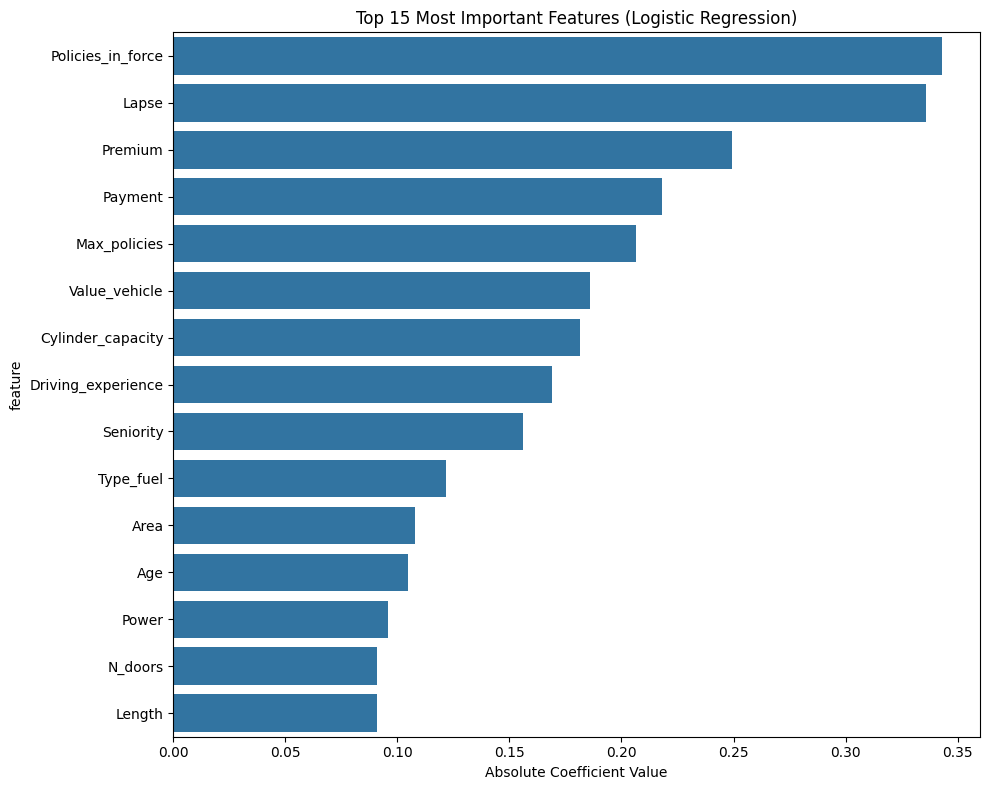


Топ-10 самых важных признаков:
               feature  importance
3    Policies_in_force    0.342834
6                Lapse    0.335701
8              Premium    0.249149
7              Payment    0.218209
4         Max_policies    0.206618
15       Value_vehicle    0.186070
14   Cylinder_capacity    0.181452
21  Driving_experience    0.169068
2            Seniority    0.155869
17           Type_fuel    0.121523

Построение кривой калибровки...


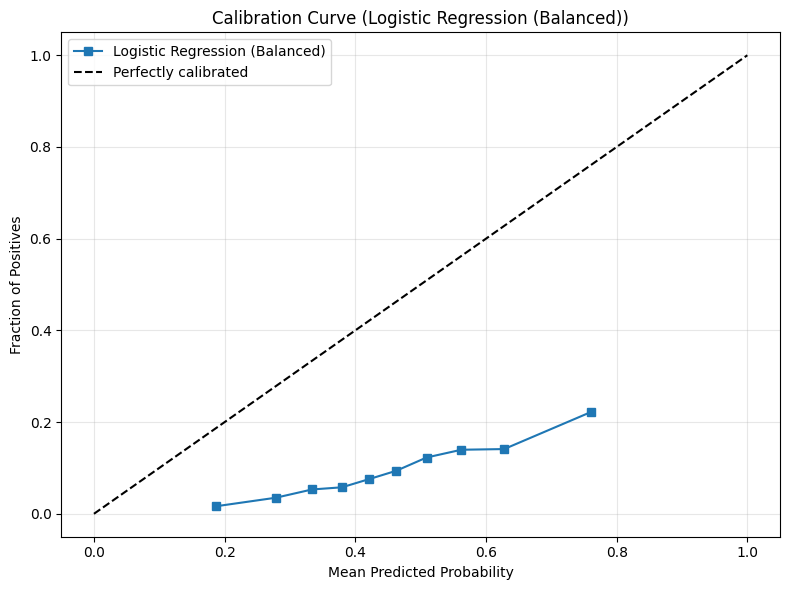

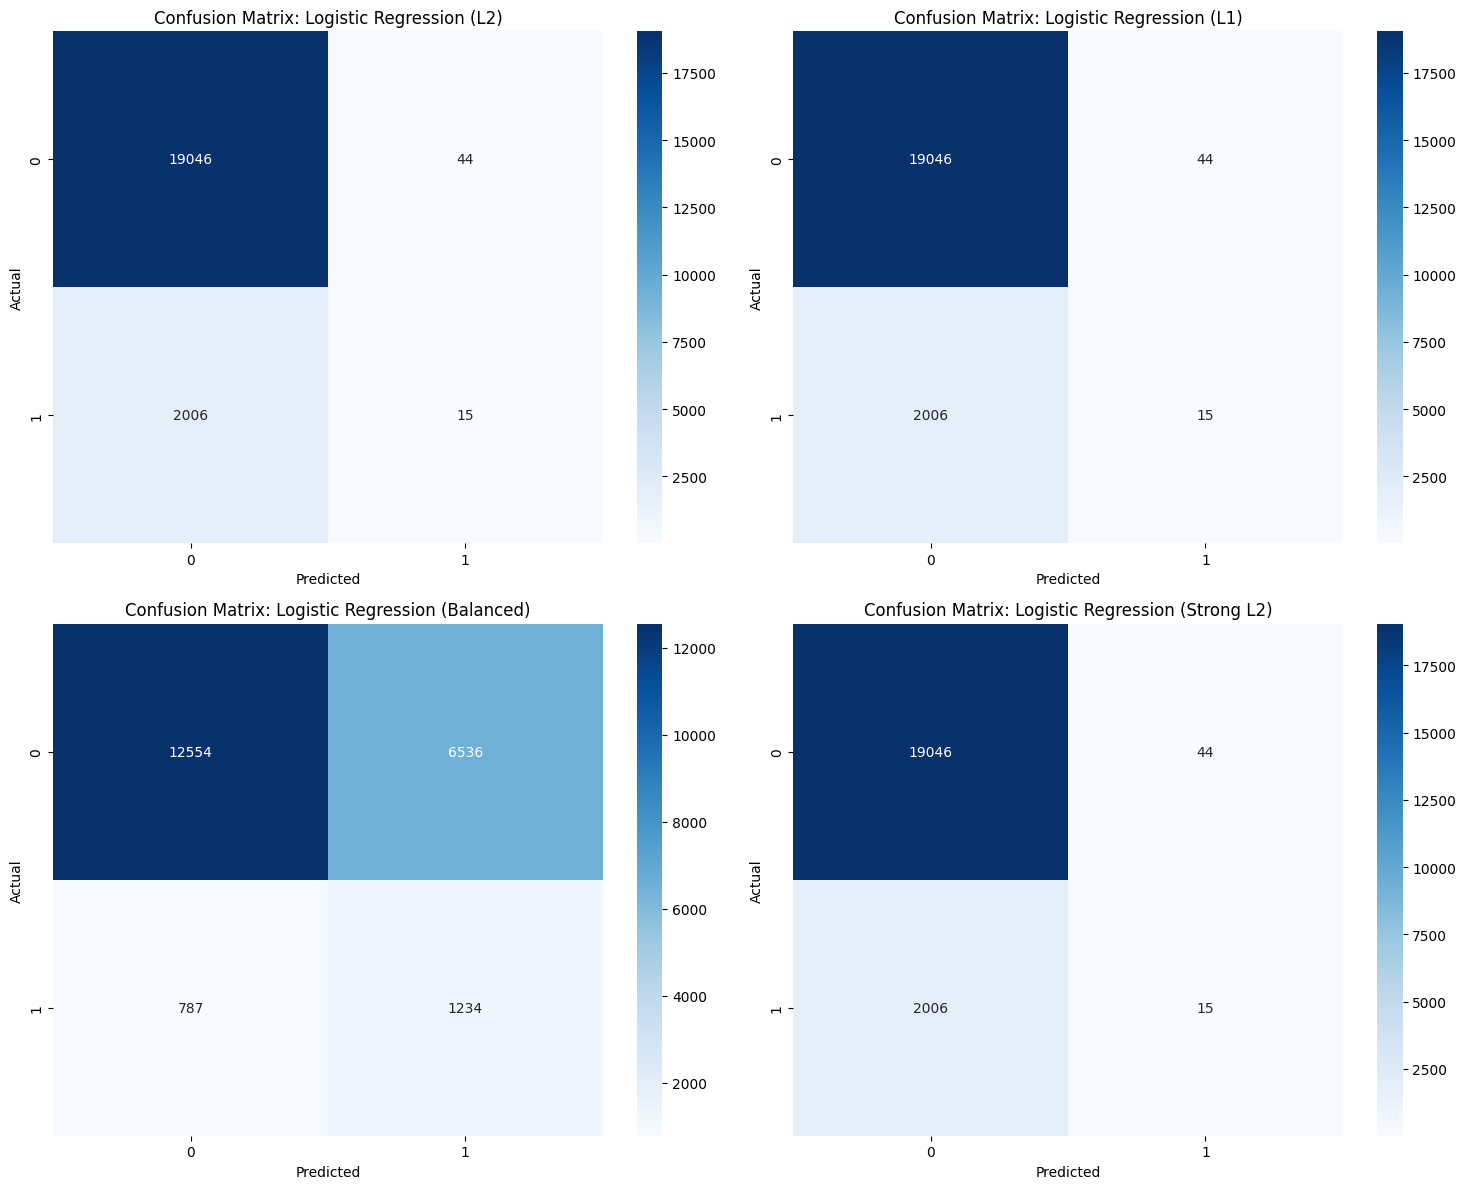

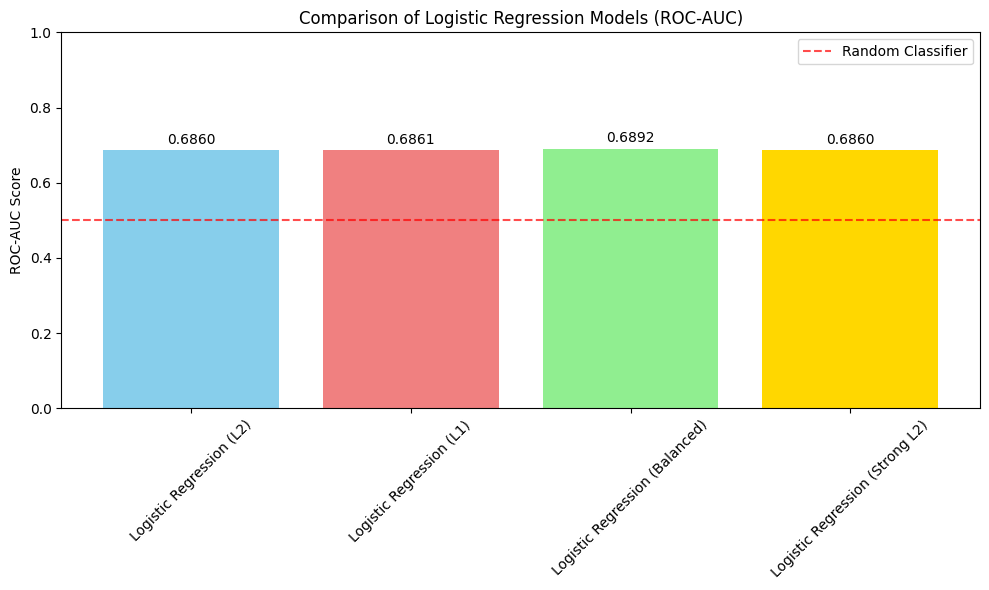


ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
Модель: Logistic Regression (Balanced)

Параметры модели:
  Коэффициент регуляризации C: 1.0
  Penalty: l2
  Class weight: balanced

Топ-15 признаков по абсолютному влиянию:
               Feature  Coefficient  Abs_Coefficient
3    Policies_in_force     0.342834         0.342834
6                Lapse    -0.335701         0.335701
8              Premium     0.249149         0.249149
7              Payment     0.218209         0.218209
4         Max_policies     0.206618         0.206618
15       Value_vehicle    -0.186070         0.186070
14   Cylinder_capacity     0.181452         0.181452
21  Driving_experience    -0.169068         0.169068
2            Seniority    -0.155869         0.155869
17           Type_fuel    -0.121523         0.121523
10                Area     0.108025         0.108025
20                 Age     0.104891         0.104891
13               Power     0.095632         0.095632
16             N_doors     0.091113         0.091113

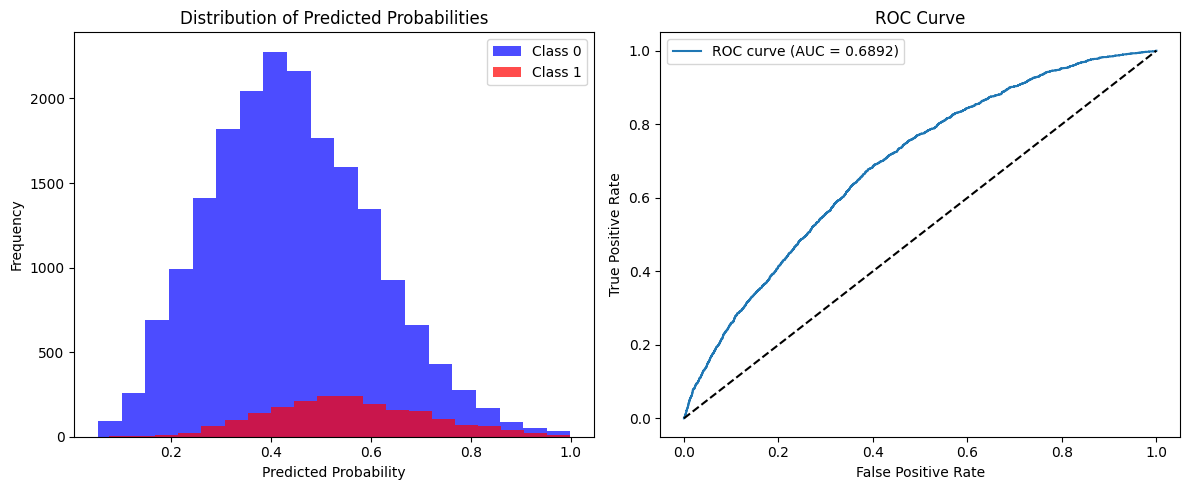


РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ
⚠️  ROC-AUC ниже 0.7 - модель требует значительного улучшения
   Рекомендации:
   - Добавьте больше признаков
   - Попробуйте другие алгоритмы
   - Проверьте качество данных

СРАВНЕНИЕ С НЕЙРОННОЙ СЕТЬЮ
Сравнение с нейронной сетью:
                          ROC-AUC       MAE       MAPE  Accuracy  Precision  \
Best Logistic Regression  0.68919  0.442113  44.705952  0.653119   0.158816   
Neural Network            0.73690  0.158000   0.000000  0.000000   0.000000   

                            Recall  F1-Score  
Best Logistic Regression  0.610589  0.252068  
Neural Network            0.000000  0.000000  

🏆 Нейронная сеть превосходит логистическую регрессию на 0.0477 по ROC-AUC

Обучение завершено!


In [18]:
for model_name, model in models_config.items():
    print(f"\n--- Обучение: {model_name} ---")
    
    # Обучение модели
    model.fit(X_train_scaled, y_train)
    
    # Оценка модели
    metrics, cm, report, y_pred_proba, y_pred = evaluate_model_comprehensive(
        model, X_test_scaled, y_test, model_name
    )
    
    # Сохранение результатов
    results[model_name] = {
        'model': model,
        'metrics': metrics,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred
    }
    
    # Вывод метрик
    print("Метрики:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Сравнение всех моделей
print("\n" + "="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
print("="*60)

# Создаем DataFrame для сравнения
metrics_comparison = pd.DataFrame({name: result['metrics'] for name, result in results.items()})
print("\nСравнительная таблица метрик:")
print(metrics_comparison.T)

# Находим лучшую модель по ROC-AUC
best_model_name = metrics_comparison.loc['ROC-AUC'].idxmax()
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]['metrics']

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"ROC-AUC: {best_metrics['ROC-AUC']:.4f}")

# Визуализация результатов
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

# 1. Важность признаков для лучшей модели
print("\nАнализ важности признаков...")
feature_importance = plot_feature_importance(best_model, X.columns)

if feature_importance is not None:
    print("\nТоп-10 самых важных признаков:")
    print(feature_importance.head(10))

# 2. Кривая калибровки для лучшей модели
print("\nПостроение кривой калибровки...")
plot_calibration_curve(y_test, results[best_model_name]['y_pred_proba'], best_model_name)

# 3. Матрица ошибок для всех моделей
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (model_name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix: {model_name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 4. Сравнение ROC-AUC всех моделей
plt.figure(figsize=(10, 6))
models_list = list(results.keys())
roc_auc_scores = [results[name]['metrics']['ROC-AUC'] for name in models_list]

bars = plt.bar(models_list, roc_auc_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Classifier')
plt.ylabel('ROC-AUC Score')
plt.title('Comparison of Logistic Regression Models (ROC-AUC)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()

# Добавляем значения на столбцы
for bar, score in zip(bars, roc_auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Детальный анализ лучшей модели
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

print(f"Модель: {best_model_name}")
print("\nПараметры модели:")
print(f"  Коэффициент регуляризации C: {best_model.C}")
print(f"  Penalty: {best_model.penalty}")
print(f"  Class weight: {best_model.class_weight}")

# Анализ коэффициентов
if hasattr(best_model, 'coef_'):
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_[0],
        'Abs_Coefficient': abs(best_model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nТоп-15 признаков по абсолютному влиянию:")
    print(coef_df.head(15))

# Прогнозирование на тестовых данных с лучшей моделью
print("\nПримеры прогнозов (первые 10):")
test_predictions = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted_Class': results[best_model_name]['y_pred'][:10],
    'Predicted_Probability': results[best_model_name]['y_pred_proba'][:10]
})
print(test_predictions)

# Анализ распределения вероятностей
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(results[best_model_name]['y_pred_proba'][y_test == 0], 
         alpha=0.7, label='Class 0', bins=20, color='blue')
plt.hist(results[best_model_name]['y_pred_proba'][y_test == 1], 
         alpha=0.7, label='Class 1', bins=20, color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

plt.subplot(1, 2, 2)
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, results[best_model_name]['y_pred_proba'])
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {best_metrics["ROC-AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ")
print("="*60)

# Анализ и рекомендации
if best_metrics['ROC-AUC'] < 0.7:
    print("⚠️  ROC-AUC ниже 0.7 - модель требует значительного улучшения")
    print("   Рекомендации:")
    print("   - Добавьте больше признаков")
    print("   - Попробуйте другие алгоритмы")
    print("   - Проверьте качество данных")
elif best_metrics['ROC-AUC'] < 0.8:
    print("✅ ROC-AUC удовлетворительный, но есть потенциал для улучшения")
    print("   Рекомендации:")
    print("   - Настройте гиперпараметры с помощью GridSearch")
    print("   - Попробуйте ансамблевые методы")
else:
    print("🎉 Отличный результат ROC-AUC!")

# Сравнение с нейронной сетью (если доступны метрики NN)
print("\n" + "="*60)
print("СРАВНЕНИЕ С НЕЙРОННОЙ СЕТЬЮ")
print("="*60)

# Предположим, что у вас есть метрики нейронной сети
# Замените эти значения на реальные метрики вашей нейронной сети
nn_metrics = {
    'ROC-AUC': 0.7369,  # Ваши реальные метрики
    'MAE': 0.1580,
    'MAPE': 0.0,  # Рассчитайте MAPE для NN
    'Accuracy': 0.0,
    'Precision': 0.0,
    'Recall': 0.0,
    'F1-Score': 0.0
}

comparison_with_nn = pd.DataFrame({
    'Best Logistic Regression': best_metrics,
    'Neural Network': nn_metrics
})

print("Сравнение с нейронной сетью:")
print(comparison_with_nn.T)

# Определение лучшей модели
if best_metrics['ROC-AUC'] > nn_metrics['ROC-AUC']:
    print(f"\n🏆 Логистическая регрессия превосходит нейронную сеть на {best_metrics['ROC-AUC'] - nn_metrics['ROC-AUC']:.4f} по ROC-AUC")
else:
    print(f"\n🏆 Нейронная сеть превосходит логистическую регрессию на {nn_metrics['ROC-AUC'] - best_metrics['ROC-AUC']:.4f} по ROC-AUC")

print("\nОбучение завершено!")